In [1]:
from dataloader import load_balanced_binary_dataset
import backend.src.utils.utils as utils

In [2]:
data = load_balanced_binary_dataset()
data = utils.clean_text(data, "text")

In [3]:
data

,sent_id,text,label
1875,001670-05-04,singelen cover of darkness tredjesporet two ki...,1
4263,200006-39-01,forslag vibrasjonsalarmen bør settes oppnår øn...,1
2330,202276-14-01,futt,1
4929,000735-08-02,hjelp historie skrevet dc comics egne forfatte...,1
2630,500921-06-02,intenst kammerspill fremstår familien stor tro...,1
...,...,...,...
1938,100122-05-01,dessverre makter buzz the pop quiz,0
1504,107563-04-04,virker filmen unnskylde åpner hele lageret vel...,0
1441,700471-05-04,rare gutten organiserer band setter sammen mus...,0
4700,400215-08-02,dermed ødelegges potensielle spenningskurven litt,0


In [4]:
from collections import Counter
import math

num_words = Counter()
for review in data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
num_words = math.ceil(num_words / 1000) * 1000
print("Number of words:", num_words)

Number of words: 13000


<AxesSubplot:>

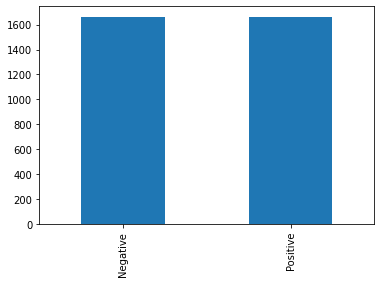

In [5]:
data["label"].replace({0: "Negative", 1: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

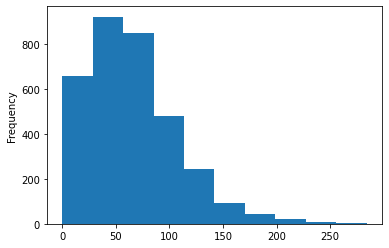

In [6]:
data["text"].str.len().plot.hist()

In [7]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

X_train, X_val, y_train, y_val = train_test_split(data["text"], data["label"], test_size=0.2, random_state=42,
                                                  shuffle=True)

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

print("X_train size:", len(X_train))
print("y_train size:", len(y_train))
print("X_val size:", len(X_val))
print("y_val size:", len(y_val))

X_train size: 2660
y_train size: 2660
X_val size: 666
y_val size: 666


In [8]:
from random import randint

random_idx = randint(0, len(X_train))
review_label_mapping = {0: "Negative", 1: "Positive"}
review_label = review_label_mapping[int(y_train.iloc[random_idx])]

print(f"Review {random_idx} contains {len(X_train[random_idx])} words and is {review_label}")
print("Review content:", end="\n\n")
print(" ".join(tokenizer.index_word[idx] for idx in X_train[random_idx]))

Review 2128 contains 5 words and is Negative
Review content:

tillegg bada støtten dårlig nettsteder


In [9]:
word_counter = Counter()
for review in X_train:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [10]:
word_counter.most_common(10)

[('litt', 148),
 ('gjør', 87),
 ('filmen', 83),
 ('får', 83),
 ('godt', 81),
 ('nok', 70),
 ('helt', 65),
 ('the', 63),
 ('hele', 62),
 ('to', 62)]

In [11]:
import numpy as np

maxlen = 150

X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

y_train = np.array(y_train)
y_val = np.array(y_val)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (2660, 150)
X_val shape: (666, 150)
y_train shape: (2660,)
y_val shape: (666,)


In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128))
model.add(LSTM(units=128, dropout=0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [13]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1664000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,795,713
Trainable params: 1,795,713
Non-trainable params: 0
_________________________________________________________________


In [14]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
167/167 [==============================] - 42s 234ms/step - loss: 0.6878 - accuracy: 0.5496 - val_loss: 0.6689 - val_accuracy: 0.6126
Epoch 2/20
167/167 [==============================] - 33s 196ms/step - loss: 0.4462 - accuracy: 0.8154 - val_loss: 0.6969 - val_accuracy: 0.6622
Epoch 3/20
167/167 [==============================] - 35s 208ms/step - loss: 0.1550 - accuracy: 0.9417 - val_loss: 0.8198 - val_accuracy: 0.6547
Epoch 4/20
167/167 [==============================] - 35s 212ms/step - loss: 0.0546 - accuracy: 0.9808 - val_loss: 0.9713 - val_accuracy: 0.6577
Epoch 5/20
167/167 [==============================] - 34s 206ms/step - loss: 0.0214 - accuracy: 0.9936 - val_loss: 1.1606 - val_accuracy: 0.6532


In [15]:
from datetime import datetime

model.save(f"models/SA-LSTM-BINARY-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

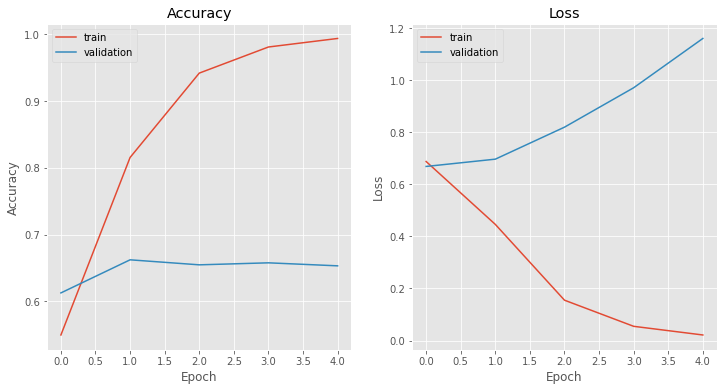

In [16]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [17]:
# Evaluation
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

21/21 [==============================] - 2s 101ms/step - loss: 1.1606 - accuracy: 0.6532
Validation loss: 1.1605745553970337
Validation accuracy: 0.6531531810760498
